Here we do an exploration of the data and derive two models, one with 46 dummy variables for the numbers various room types, and one with 4 quantitative variables for the numbers of various room types.  We save the results and (in other files) test which model produces results with lower (preferred) AIC.  Spoiler alert: dummy variables wins by an incredible margin!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv("../data/raw/DC_Properties.csv")

/home/sean/Code/incoming/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (18,19,20,21,22,23,24,33,34,35,37,43,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

Unnamed: 0  BATHRM  HF_BATHRM           HEAT AC  NUM_UNITS  ROOMS  BEDRM  \
0           0       4          0      Warm Cool  Y        2.0      8      4   
1           1       3          1      Warm Cool  Y        2.0     11      5   
2           2       3          1  Hot Water Rad  Y        2.0      9      5   
3           3       3          1  Hot Water Rad  Y        2.0      8      5   
4           4       2          1      Warm Cool  Y        1.0     11      3   

      AYB  YR_RMDL  ...  LONGITUDE  ASSESSMENT_NBHD ASSESSMENT_SUBNBHD  \
0  1910.0   1988.0  ... -77.040832       Old City 2   040 D Old City 2   
1  1898.0   2007.0  ... -77.040764       Old City 2   040 D Old City 2   
2  1910.0   2009.0  ... -77.040678       Old City 2   040 D Old City 2   
3  1900.0   2003.0  ... -77.040629       Old City 2   040 D Old City 2   
4  1913.0   2012.0  ... -77.039361       Old City 2   040 D Old City 2   

   CENSUS_TRACT CENSUS_BLOCK    WARD  SQUARE          X          Y QUADRANT  
0        4201.0  004201 2006  Ward 2     152 -77.040429  38.914881       NW  
1        4201.0  004201 2006  Ward 2     152 -77.040429  38.914881       NW  
2        4201.0  004201 2006  Ward 2     152 -77.040429  38.914881       NW  
3        4201.0  004201 2006  Ward 2     152 -77.040429  38.914881       NW  
4        4201.0  004201 2006  Ward 2     152 -77.040429  38.914881       NW  

[5 rows x 49 columns]

Date of last sale.  New feature to be added below: for each house, its sale date in number of days before this last sale.

In [4]:
pd.to_datetime(df.SALEDATE).max()

Timestamp('2018-07-12 00:00:00')

In [5]:
df['sold_days_before_last_sale'] = pd.to_datetime(df.SALEDATE).max() - pd.to_datetime(df.SALEDATE)

In [6]:
df['sold_days_before_last_sale'].head()

0   5343 days
1   6538 days
2    751 days
3   4383 days
4         NaT
Name: sold_days_before_last_sale, dtype: timedelta64[ns]

We will have 13 dummy variables for bathroom instead of 1 quantitative variable.

In [7]:
df.BATHRM.value_counts()

1     74555
2     53325
3     20785
4      8119
5      1367
6       500
7       129
8        71
0        58
9        22
10       14
11        7
12        3
14        1
13        1
Name: BATHRM, dtype: int64

In [8]:
df.HF_BATHRM.value_counts()

0     93148
1     59258
2      6186
3       289
4        56
5        12
7         3
6         3
11        1
9         1
Name: HF_BATHRM, dtype: int64

In [9]:
df.BEDRM.value_counts()

3     57864
2     34946
4     24893
1     24181
5      6898
0      5297
6      3090
8       792
7       750
9       123
10       62
12       34
11       13
13        4
15        3
14        2
16        2
20        1
19        1
24        1
Name: BEDRM, dtype: int64

In [10]:
df.KITCHENS.value_counts()

1.0     90434
2.0     11904
4.0      3051
3.0      1173
0.0       117
5.0        11
6.0         4
44.0        1
Name: KITCHENS, dtype: int64

In [11]:
df.ROOMS.value_counts()

6     37259
7     22338
4     20593
3     17759
5     16852
8     16327
9      7616
10     5909
2      5294
12     2929
11     2364
16     1346
13      766
14      595
15      310
20      148
0       138
18      124
1        96
17       77
19       41
21       20
22       10
23       10
24       10
25        6
28        5
27        2
39        2
41        1
34        1
40        1
37        1
35        1
29        1
32        1
31        1
30        1
26        1
48        1
Name: ROOMS, dtype: int64

In [12]:
df['sold_days_before_last_sale'].isna().value_counts()

False    132187
True      26770
Name: sold_days_before_last_sale, dtype: int64

In [13]:
df['PRICE'].isna().value_counts()

False    98216
True     60741
Name: PRICE, dtype: int64

In [14]:
df['NUM_UNITS'].value_counts()

1.0    92491
2.0     9864
4.0     3059
3.0     1101
0.0      168
5.0       10
6.0        3
Name: NUM_UNITS, dtype: int64

In [15]:
h = df[df['NUM_UNITS']==1]

ho is properties with non-null PRICE.

In [16]:
ho = h[~h['PRICE'].isna()]

houses is properties with non-null PRICE and SALEDATES

In [17]:
houses = ho[~ho['sold_days_before_last_sale'].isna()]

In [18]:
len(houses)

49338

In [19]:
houses.NUM_UNITS.value_counts()

1.0    49338
Name: NUM_UNITS, dtype: int64

houses.PRICE needs to be reexpressed.  Displaying without reexpression then trying log.

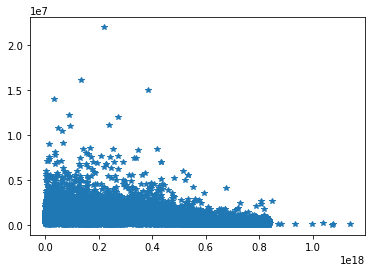

In [20]:
plt.plot(houses.sold_days_before_last_sale, houses.PRICE, '*')

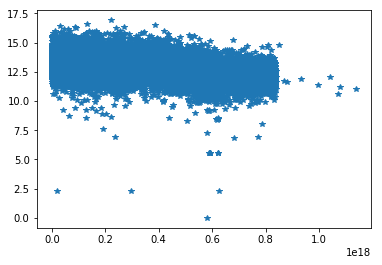

In [21]:
plt.plot(houses.sold_days_before_last_sale, np.log(houses.PRICE), '*')

In [22]:
len(houses[houses['PRICE'] >= 1000000])

5673

Remove houses after 10 year (520 week) window.

In [23]:
Houses = houses[houses.sold_days_before_last_sale < pd.Timedelta(weeks=520)]

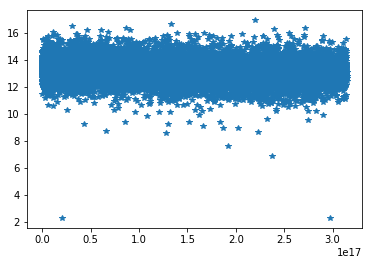

In [24]:
plt.plot(Houses.sold_days_before_last_sale, np.log(Houses.PRICE), '*')

In [25]:
Houses.PRICE.sort_values().head(20)

74419       10.0
81594       10.0
69264     1000.0
96378     2000.0
87541     5185.0
96261     5522.0
68268     5964.0
86612     7500.0
88346     7500.0
60482     9125.0
73991    10000.0
91609    10000.0
89399    12236.0
45044    12261.0
26014    12365.0
68061    14000.0
17936    15000.0
86740    18000.0
52585    20000.0
91997    20750.0
Name: PRICE, dtype: float64

Drop outliers with PRICE less then 5000.  These might have been sweetheart deals that don't reflect true value of home.

In [26]:
HousesWithCheap = houses[houses.sold_days_before_last_sale < pd.Timedelta(weeks=520)]

In [27]:
HousesWithCheap[HousesWithCheap['PRICE'] < 5000].loc[:,'FULLADDRESS']

69264          3428 9TH STREET NE
74419    1101 HOLBROOK TERRACE NE
81594          320 34TH STREET NE
96378            2902 P STREET SE
Name: FULLADDRESS, dtype: object

According to Google, the houses at these addresses are worth much more than $5000.  Removing these outliers.  All of these houses have estimated values between 300K and 500K on Redfin or Zillow.  OK to eliminate.  There are probably more that can be eliminate.

In [28]:
Houses = Houses[Houses['PRICE']>=5000]

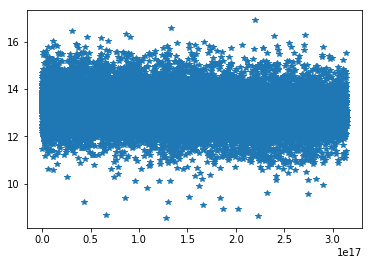

In [29]:
plt.plot(Houses.sold_days_before_last_sale, np.log(Houses.PRICE), '*')

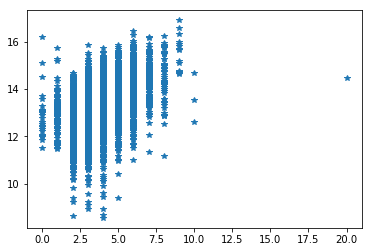

In [30]:
plt.plot(Houses.BEDRM, np.log(Houses.PRICE),'*')

The outlier is real.  Can't eliminate it.  I looked up the address on Redfin.  Cheap for 20 Rooms.

In [31]:
Houses[Houses.BEDRM==20].loc[:,'FULLADDRESS']

3076    1825 13TH STREET NW
Name: FULLADDRESS, dtype: object

In [32]:
Houses['extra_rooms'] = Houses.ROOMS - Houses.BEDRM

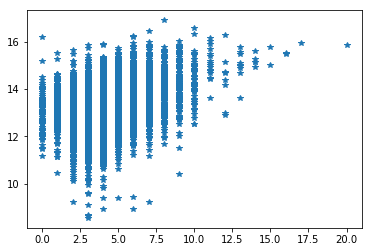

In [33]:
plt.plot(Houses.extra_rooms, np.log(Houses.PRICE), '*')

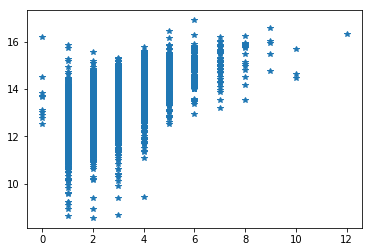

In [34]:
plt.plot(Houses.BATHRM, np.log(Houses.PRICE), '*')

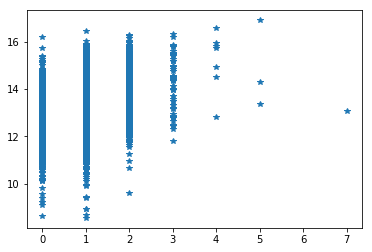

In [35]:
plt.plot(Houses.HF_BATHRM, np.log(Houses.PRICE), '*')

In [36]:
Houses['MPlus'] = (Houses.PRICE > 1000000)

In [37]:
Houses[['PRICE','MPlus']].head()

PRICE  MPlus
5   1950000.0   True
16  1240000.0   True
20    33232.0  False
23  1065000.0   True
24  1100000.0   True

In [38]:
X_feats = ['sold_days_before_last_sale', 'BEDRM', 'BATHRM', 'HF_BATHRM', 'extra_rooms']
y = Houses.MPlus

In [39]:
Houses[X_feats].head()

sold_days_before_last_sale  BEDRM  BATHRM  HF_BATHRM  extra_rooms
5                   3058 days      5       3          2            5
16                  2807 days      3       3          1            5
20                   912 days      5       3          1            9
23                  2151 days      3       2          1            2
24                  2178 days      3       2          1            5

In [40]:
Cols = X_feats + ['MPlus', 'PRICE']

In [41]:
Cols

['sold_days_before_last_sale',
 'BEDRM',
 'BATHRM',
 'HF_BATHRM',
 'extra_rooms',
 'MPlus',
 'PRICE']

In [42]:
Houses[Cols].head(10)

sold_days_before_last_sale  BEDRM  BATHRM  HF_BATHRM  extra_rooms  MPlus  \
5                    3058 days      5       3          2            5   True   
16                   2807 days      3       3          1            5   True   
20                    912 days      5       3          1            9  False   
23                   2151 days      3       2          1            2   True   
24                   2178 days      3       2          1            5   True   
72                   1373 days      3       4          2            5  False   
73                   3326 days      2       2          1            5  False   
96                   1423 days      3       2          1            4   True   
115                  1847 days      4       3          0            4   True   
119                   346 days      5       3          1            6   True   

         PRICE  
5    1950000.0  
16   1240000.0  
20     33232.0  
23   1065000.0  
24   1100000.0  
72    993500.0  
73    745000.0  
96   1280000.0  
115  2150000.0  
119  1625000.0

In [43]:
f = open("HousesQuantitative.pickle","wb")
pickle.dump(Houses,f)
pickle.dump(X_feats,f)
pickle.dump('MPlus',f)
f.close()

In [44]:
df_new = Houses[X_feats].copy()

In [45]:
bed_rooms_dummies = pd.get_dummies(df_new.BEDRM, prefix="BEDRM", drop_first=True)
df_new = pd.concat([df_new, bed_rooms_dummies], axis=1)
df_new.drop("BEDRM", axis=1, inplace=True)

In [46]:
len(df_new.columns)

15

In [47]:
bathroom_dummies = pd.get_dummies(df_new.BATHRM, prefix="BATHRM", drop_first=True)
df_new = pd.concat([df_new, bathroom_dummies], axis=1)
df_new.drop("BATHRM", axis=1, inplace=True)

In [48]:
len(df_new.columns)

25

In [49]:
half_bath_dummies = pd.get_dummies(df_new.HF_BATHRM, prefix="HF_BATHRM", drop_first=True)
df_new = pd.concat([df_new, half_bath_dummies], axis=1)
df_new.drop("HF_BATHRM", axis=1, inplace=True)

In [50]:
len(df_new.columns)

30

In [51]:
extra_rooms_dummies = pd.get_dummies(df_new.extra_rooms, prefix="extra_rooms", drop_first=True)
df_new = pd.concat([df_new, extra_rooms_dummies], axis=1)
df_new.drop("extra_rooms", axis=1, inplace=True)

In [52]:
len(df_new.columns)

47

In [53]:
dummy_features = list(df_new.columns)

In [54]:
df_new = pd.concat([df_new, Houses.MPlus], axis=1)

In [55]:
f = open("HousesDummy.pickle","wb")
pickle.dump(df_new,f)
pickle.dump(dummy_features,f)
pickle.dump('MPlus',f)
f.close()